# Text mining 
## Lab 06 Linear Regression on Job Offers

We are going to train a Linear Regression model to predict position salary based on Job Offer.

For this puprose we'll use Tensorflow, and sklearn. Your job is to fill in the missing code into the cells below.

You will find the steps you need to perform in the **Task** section in each cell.

In [0]:
%matplotlib inline
import pandas
import random
import requests
import os.path

import tensorflow as tf
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

In [0]:
def next_batch(x_, y_, batch_size, ids = None):
  if (ids is None):
    # Random sample from the dataset. It can be sequential (but must be shuffled) within epoch, that will guarantee that you'll use all the data.
    # The two approaches are practically equal when using a large number of epochs.
    ids = np.random.choice(x_.shape[0], batch_size, replace=False)
  
  
  feed_dict = {
      x: x_[ids],
      y: y_[ids]
  }
  
  return feed_dict

In [0]:
hparams = tf.contrib.training.HParams(
    batch_size = 32,
    max_epochs = 500,
    # Lambda
    reg_param = 0.01,
    # Alpha 
    learning_rate = 1,
    # Number of features
    max_words = 15000,
    # Priting error information after display_step epochs
    display_step = 1
)

# Download the dataset

We are going to download the dataset and load it into a pandas DataFrame

In [0]:
def download_file(filename, url):
    """
    Download an URL to a file
    """
    with open(filename, 'wb') as fout:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        # Write response data to file
        for block in response.iter_content(4096):
            fout.write(block)
            
def download_if_not_exists(filename, url):
    """
    Download a URL to a file if the file
    does not exist already.
    Returns
    -------
    True if the file was downloaded,
    False if it already existed
    """
    if not os.path.exists(filename):
        download_file(filename, url)
        return True
    return False
  
  
download_if_not_exists('salary-train.csv', 'https://raw.githubusercontent.com/tyz910/hse-shad-ml/master/10-statement-linreg/salary-train.csv')

False

In [0]:
salaries = pandas.read_csv('salary-train.csv').sample(10000)
salaries.head()

FullDescription LocationNormalized  \
26546  Knowledge of Fund platform / commercial contra...            Redhill   
20527  NOC Datacentre Engineer The successful candida...        Farnborough   
17182  Project portfolio manager **** p/hr Our client...            Reading   
10809  Server Support / NettApp / Xen / SAN / Citrix ...      West Midlands   
32068  CNC Laser / EDM Operator  Salary Neg  Location...         Portsmouth   

      ContractTime  SalaryNormalized  
26546     contract             22000  
20527    permanent             17500  
17182     contract             37440  
10809     contract             48000  
32068          NaN             25000

# Preporcessing

Doing basic preprocessing. 

1. The text is transformed to lower case.
2. Removing all non alpha-numeric symbols
3. Filling up all missing values with NA

In [0]:
# For beginning, transform train['FullDescription'] to lowercase using text.lower()
salaries['FullDescription'].str.lower()

# Then replace everything except the letters and numbers in the spaces.
# it will facilitate the further division of the text into words.
salaries['FullDescription'].replace('[^a-zA-Z0-9]', ' ', regex = True)

# Replace NaN in LocationNormalized и ContractTime rows to special string 'nan'. 
salaries['LocationNormalized'].fillna('nan', inplace=True)
salaries['ContractTime'].fillna('nan', inplace=True)

# Train and test split

In [0]:
random.seed(42)
all_idx = list(range(salaries.shape[0]))

random.shuffle(all_idx)
train_size = int(0.8 * len(all_idx))
test_size = int(0.1 * len(all_idx))
validation_size = int(0.1 * len(all_idx))

assert salaries.shape[0] == (train_size + test_size + validation_size)

train_idx = all_idx[:train_size]
test_idx = all_idx[train_size:(train_size + test_size)]
validation_idx = all_idx[-validation_size:]

train_salaries = salaries.iloc[train_idx]
test_salaries = salaries.iloc[test_idx ]
validation_salaries = salaries.iloc[validation_idx]

y_train = train_salaries['SalaryNormalized'].values
y_test = test_salaries['SalaryNormalized'].values
y_validation = validation_salaries['SalaryNormalized'].values

# Feature Engineering

Here we do basic plots of features contained in the dataset. You can design more features and plot them using the sns.pairplot.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


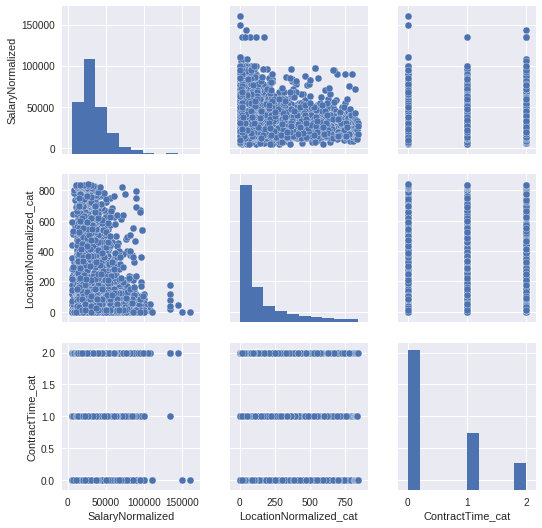

In [0]:
def string_indexer(unique_values):
  return dict(zip(unique_values, list(range(len(unique_values)))))
             
index = string_indexer(train_salaries['LocationNormalized'].unique())
train_salaries['LocationNormalized_cat'] = train_salaries['LocationNormalized'].apply(lambda x: index.get(x))

index = string_indexer(train_salaries['ContractTime'].unique())
train_salaries['ContractTime_cat'] = train_salaries['ContractTime'].apply(lambda x: index.get(x))

sns.pairplot(train_salaries[['SalaryNormalized', 'LocationNormalized_cat', 'ContractTime_cat']])

# Data vectorization

Here we use binary encoded vectors, and concatenate the other features to the text matrices.

In [0]:
tokenizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=hparams.max_words, binary=True)
x_train = tokenizer.fit_transform(train_salaries['FullDescription']).toarray()
x_test = tokenizer.transform(test_salaries['FullDescription']).toarray()
x_validation = tokenizer.transform(validation_salaries['FullDescription']).toarray()

print('train shape:', x_train.shape)
print('test shape:', x_test.shape)
print('validation shape:', x_validation.shape)

del salaries

train shape: (8000, 15000)
test shape: (1000, 15000)
validation shape: (1000, 15000)


In [0]:
enc = DictVectorizer()
scaler = StandardScaler()

# Don't have to make them Dense, easier for initial version
X_train_categ = np.array(enc.fit_transform(train_salaries[['LocationNormalized', 'ContractTime']].to_dict('records')).todense())
X_test_categ = np.array(enc.transform(test_salaries[['LocationNormalized', 'ContractTime']].to_dict('records')).todense())
X_validation_categ = np.array(enc.transform(validation_salaries[['LocationNormalized', 'ContractTime']].to_dict('records')).todense())

X_train_numer = scaler.fit_transform(np.array([len(x) for x in train_salaries['FullDescription']]).reshape(-1, 1))
X_test_numer = scaler.fit_transform(np.array([len(x) for x in test_salaries['FullDescription']]).reshape(-1, 1))
X_validation_numer = scaler.fit_transform(np.array([len(x) for x in validation_salaries['FullDescription']]).reshape(-1, 1))

print(X_train_categ.shape)
print(X_train_numer.shape)

x_train = np.hstack([x_train, X_train_categ, X_train_numer])
x_test = np.hstack([x_test, X_test_categ, X_test_numer])
x_validation = np.hstack([x_validation, X_validation_categ, X_validation_numer])

print(x_test.shape)


del train_salaries, X_train_categ, X_train_numer
del test_salaries, X_test_categ, X_test_numer
del validation_salaries, X_validation_categ, X_validation_numer

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(8000, 843)
(8000, 1)
(1000, 15844)


# Model initilization

## Linear Regression

$ \hat{y} = x^\top w + b$

## Loss functions

### Root mean squared error

$ \mathcal{L}_{RMSE} = \sqrt{\frac{1}{2 * N} \sum_{i = 1}^N (y_{i}  - \hat{y}_{i} ) ^ 2} $

### Mean absolute error

$ \mathcal{L}_{MAE} = \frac{1}{2 * N} \sum_{i = 1}^N | y_{i}  - \hat{y}_{i}| $

## L2 reg

$ \mathcal{L}_{l2} = \mathcal{L} +  \frac{\lambda}{2} \sum_{j = 1}^M w_j ^2$

## Tasks
1. Implement linear regression using the formulas above;
2. Implement RMSE and MAE (you can use both for optimization)

In [0]:
features = x_train.shape[1]

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None, features))
y = tf.placeholder(tf.float32)


W = tf.Variable(tf.random_normal([features, 1]), name="W")
b = tf.Variable(0.0)

pred = tf.matmul(x, W) + b

rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(pred, y)) / 2.0)
mae = tf.reduce_mean(tf.abs(y - pred)) / 2.0

cost = rmse + hparams.reg_param / 2.0 * tf.reduce_sum(tf.matmul(tf.transpose(W), W))
optimizer = tf.train.GradientDescentOptimizer(hparams.learning_rate).minimize(cost)

In [0]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
# Start training
sess = tf.Session()
sess.run(init)

In [0]:
# Training cycle
for epoch in range(hparams.max_epochs):
    avg_cost = 0.
    total_batch = int(x_train.shape[0]/hparams.batch_size)
    # Loop over all batches
    for i in range(total_batch):
        feed_dict = next_batch(x_train, y_train, hparams.batch_size)
        
        # Fit training using batch data
        _,  c = sess.run([optimizer ,cost], feed_dict=feed_dict)

        # Compute average loss
        avg_cost += c / total_batch
    # Display logs per epoch step
    if (epoch+1) % hparams.display_step == 0:
#             print(sess.run(W))
        print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
  
print ("Optimization Finished!")

Epoch: 0001 cost= 26284.780531250
Epoch: 0002 cost= 26502.574078125
Epoch: 0003 cost= 26234.174023437
Epoch: 0004 cost= 26221.977882813
Epoch: 0005 cost= 26293.504015625
Epoch: 0006 cost= 26069.857054687
Epoch: 0007 cost= 26027.903773438
Epoch: 0008 cost= 25651.051281250
Epoch: 0009 cost= 25733.461156250
Epoch: 0010 cost= 25531.897539062
Epoch: 0011 cost= 25588.736109375
Epoch: 0012 cost= 25416.918523438
Epoch: 0013 cost= 25360.931351563
Epoch: 0014 cost= 25013.855921875
Epoch: 0015 cost= 25195.895382812
Epoch: 0016 cost= 25166.982648437
Epoch: 0017 cost= 24848.860562500
Epoch: 0018 cost= 24893.903328125
Epoch: 0019 cost= 24621.557570312
Epoch: 0020 cost= 24581.879273438
Epoch: 0021 cost= 24305.035421875
Epoch: 0022 cost= 24712.604015625
Epoch: 0023 cost= 24341.884921875
Epoch: 0024 cost= 24147.162882813
Epoch: 0025 cost= 24207.614554688
Epoch: 0026 cost= 24180.994953125
Epoch: 0027 cost= 23761.911804687
Epoch: 0028 cost= 23844.355226563
Epoch: 0029 cost= 23773.695156250
Epoch: 0030 co

Epoch: 0077 cost= 19760.675316406
Epoch: 0078 cost= 19574.670714844
Epoch: 0079 cost= 19417.750746094
Epoch: 0080 cost= 19548.231269531
Epoch: 0081 cost= 19599.571906250
Epoch: 0082 cost= 19355.162386719
Epoch: 0083 cost= 19201.964085937
Epoch: 0084 cost= 18962.925574219
Epoch: 0085 cost= 18960.013484375
Epoch: 0086 cost= 19116.245164062
Epoch: 0087 cost= 19211.325347656
Epoch: 0088 cost= 18571.109511719
Epoch: 0089 cost= 18778.023910156
Epoch: 0090 cost= 18866.586304687
Epoch: 0091 cost= 18371.789371094
Epoch: 0092 cost= 18355.603199219
Epoch: 0093 cost= 18665.235007812
Epoch: 0094 cost= 18118.880832031
Epoch: 0095 cost= 18242.411308594
Epoch: 0096 cost= 18209.116300781
Epoch: 0097 cost= 17766.676007812
Epoch: 0098 cost= 17914.841726563
Epoch: 0099 cost= 17829.336472656
Epoch: 0100 cost= 18014.187281250
Epoch: 0101 cost= 18021.769562500
Epoch: 0102 cost= 17513.486867187
Epoch: 0103 cost= 18118.292156250
Epoch: 0104 cost= 17838.743367188
Epoch: 0105 cost= 17664.604691406
Epoch: 0106 co

Epoch: 0153 cost= 14989.157027344
Epoch: 0154 cost= 15204.133652344
Epoch: 0155 cost= 15129.079267578
Epoch: 0156 cost= 14863.124652344
Epoch: 0157 cost= 14997.670498047
Epoch: 0158 cost= 14693.614654297
Epoch: 0159 cost= 14724.072207031
Epoch: 0160 cost= 14641.514765625
Epoch: 0161 cost= 14616.646380859
Epoch: 0162 cost= 14152.427460938
Epoch: 0163 cost= 14411.685039062
Epoch: 0164 cost= 14498.058367188
Epoch: 0165 cost= 14691.465062500
Epoch: 0166 cost= 14272.608501953
Epoch: 0167 cost= 14189.948878906
Epoch: 0168 cost= 14541.760525391
Epoch: 0169 cost= 14013.951427734
Epoch: 0170 cost= 14368.647785156
Epoch: 0171 cost= 14307.466142578
Epoch: 0172 cost= 14107.443910156
Epoch: 0173 cost= 14087.482390625
Epoch: 0174 cost= 14326.667974609
Epoch: 0175 cost= 14189.349648438
Epoch: 0176 cost= 14010.847525391
Epoch: 0177 cost= 14149.434171875
Epoch: 0178 cost= 13920.029820313
Epoch: 0179 cost= 13873.488578125
Epoch: 0180 cost= 13919.662789062
Epoch: 0181 cost= 13785.921738281
Epoch: 0182 co

Epoch: 0229 cost= 12942.146839844
Epoch: 0230 cost= 12778.209068359
Epoch: 0231 cost= 12698.112519531
Epoch: 0232 cost= 12737.464816406
Epoch: 0233 cost= 12861.510123047
Epoch: 0234 cost= 13111.070701172
Epoch: 0235 cost= 12630.388240234
Epoch: 0236 cost= 12767.398132812
Epoch: 0237 cost= 12801.506839844
Epoch: 0238 cost= 12749.185449219
Epoch: 0239 cost= 12975.435751953
Epoch: 0240 cost= 12572.011957031
Epoch: 0241 cost= 12483.787976563
Epoch: 0242 cost= 12682.302503906
Epoch: 0243 cost= 12713.172154297
Epoch: 0244 cost= 13033.522660156
Epoch: 0245 cost= 12585.468982422
Epoch: 0246 cost= 12563.998302734
Epoch: 0247 cost= 12470.366791016
Epoch: 0248 cost= 12235.948529297
Epoch: 0249 cost= 12782.006166016
Epoch: 0250 cost= 12800.896195312
Epoch: 0251 cost= 12696.947380859
Epoch: 0252 cost= 12604.885800781
Epoch: 0253 cost= 12739.080193359
Epoch: 0254 cost= 12814.518447266
Epoch: 0255 cost= 12617.932248047
Epoch: 0256 cost= 12591.440164063
Epoch: 0257 cost= 12453.919642578
Epoch: 0258 co

Epoch: 0305 cost= 12126.223568359
Epoch: 0306 cost= 12108.921585937
Epoch: 0307 cost= 12207.012503906
Epoch: 0308 cost= 12430.049976562
Epoch: 0309 cost= 12322.316222656
Epoch: 0310 cost= 12261.746101562
Epoch: 0311 cost= 12393.906480469
Epoch: 0312 cost= 12142.088304687
Epoch: 0313 cost= 12215.995412109
Epoch: 0314 cost= 12455.465439453
Epoch: 0315 cost= 12593.511011719
Epoch: 0316 cost= 12011.966083984
Epoch: 0317 cost= 12142.387189453
Epoch: 0318 cost= 12043.832554688
Epoch: 0319 cost= 12349.150250000
Epoch: 0320 cost= 12282.897679687
Epoch: 0321 cost= 12035.988691406
Epoch: 0322 cost= 12528.962636719
Epoch: 0323 cost= 12202.796585937
Epoch: 0324 cost= 12264.599478516
Epoch: 0325 cost= 12079.193314453
Epoch: 0326 cost= 12104.023345703
Epoch: 0327 cost= 12200.554205078
Epoch: 0328 cost= 11947.315341797
Epoch: 0329 cost= 12356.534673828
Epoch: 0330 cost= 12165.103902344
Epoch: 0331 cost= 12077.697839844
Epoch: 0332 cost= 12280.730632812
Epoch: 0333 cost= 12329.991769531
Epoch: 0334 co

Epoch: 0381 cost= 12019.954539063
Epoch: 0382 cost= 11997.467558594
Epoch: 0383 cost= 12199.060035156
Epoch: 0384 cost= 11958.196962891
Epoch: 0385 cost= 12129.442097656
Epoch: 0386 cost= 12298.111873047
Epoch: 0387 cost= 11985.667367187
Epoch: 0388 cost= 11880.255333984
Epoch: 0389 cost= 12375.511373047
Epoch: 0390 cost= 12170.047082031
Epoch: 0391 cost= 12032.979982422
Epoch: 0392 cost= 12084.707980469
Epoch: 0393 cost= 11988.809919922
Epoch: 0394 cost= 11802.657265625
Epoch: 0395 cost= 11984.812351563
Epoch: 0396 cost= 12167.286828125
Epoch: 0397 cost= 12237.359322266
Epoch: 0398 cost= 12157.780753906
Epoch: 0399 cost= 11964.999402344
Epoch: 0400 cost= 11974.433089844
Epoch: 0401 cost= 12071.757638672
Epoch: 0402 cost= 12197.892400391
Epoch: 0403 cost= 12135.215332031
Epoch: 0404 cost= 12007.378324219
Epoch: 0405 cost= 12068.761046875
Epoch: 0406 cost= 11990.307353516
Epoch: 0407 cost= 12101.127804687
Epoch: 0408 cost= 12152.765457031
Epoch: 0409 cost= 12076.490228516
Epoch: 0410 co

Epoch: 0457 cost= 12067.547865234
Epoch: 0458 cost= 11914.045873047
Epoch: 0459 cost= 11931.361279297
Epoch: 0460 cost= 11760.245826172
Epoch: 0461 cost= 12094.557677734
Epoch: 0462 cost= 12226.059890625
Epoch: 0463 cost= 12184.438988281
Epoch: 0464 cost= 12166.237470703
Epoch: 0465 cost= 12120.228509766
Epoch: 0466 cost= 12265.235054687
Epoch: 0467 cost= 12000.696183594
Epoch: 0468 cost= 12166.695976563
Epoch: 0469 cost= 11881.632160156
Epoch: 0470 cost= 12008.012740234
Epoch: 0471 cost= 11722.973687500
Epoch: 0472 cost= 11906.098099609
Epoch: 0473 cost= 11835.913029297
Epoch: 0474 cost= 12019.187314453
Epoch: 0475 cost= 12213.707191406
Epoch: 0476 cost= 11904.731763672
Epoch: 0477 cost= 12346.702119141
Epoch: 0478 cost= 11875.888900391
Epoch: 0479 cost= 12050.158111328
Epoch: 0480 cost= 11941.750072266
Epoch: 0481 cost= 12012.208953125
Epoch: 0482 cost= 12155.937359375
Epoch: 0483 cost= 12032.240357422
Epoch: 0484 cost= 12020.625464844
Epoch: 0485 cost= 11837.248902344
Epoch: 0486 co

In [0]:
print ("Test (RMSE, MAE):", sess.run([rmse, mae], feed_dict = next_batch(x_test, y_test, len(x_test))))
print ("Validation (RMSE, MAE):", sess.run([rmse, mae], feed_dict = next_batch(x_validation, y_validation, len(x_validation))))

Test (RMSE, MAE): [12265.55, 6465.814]
Validation (RMSE, MAE): [12238.881, 6457.211]


# Homework

1. Design at least two new features;
2. Test your features by adding each one and measuring the RMSE and MAE, on both train and testing data;
3. (Hyper-params tuning) Experiment with different values for the Learning Rate (alpha) and Regularization param (lambda), num epochs, and etc.;
4. Report your results as an Excel table in Moodle.


You need to use validation set to test and improve your models. Use the test dataset just for prove of your model capabilities.

||FEATURES || HYPER-PARAMS || TRAIN RMSE || TRAIN MAE || TEST RMSE || TEST MAE || VALIDATION .... ||
------------------------------------------------------------------
||Uni-grams binary  || lr = 0.1, epochs=2,...    || 12341.2 || 11234.4  || 11990.296 || 12925.23 || .... ||